# Homework 3 (DUE: 11:59pm HKT, March 17)
*This notebook show all coding tasks you need to cope with. Please finish code between ### YOUR CODE HERE and ### END YOUR CODE in segmentation.py. For submission, please zip and upload your folder containing this notebook, segmentation.py and all required files for excution.*

This assignment covers two parts: K-Means clustering, and K-Means for image segmentation.

In [5]:
##
### Setup
from google.colab import drive
drive.mount('/content/drive')


FOLDERNAME = 'School/TA/CSCI3330/hw3'
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/My Drive/School/TA/CSCI3330/hw3'
/content


## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering and Mean Shift clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.

## Part 1. Clustering Algorithms (60 points)

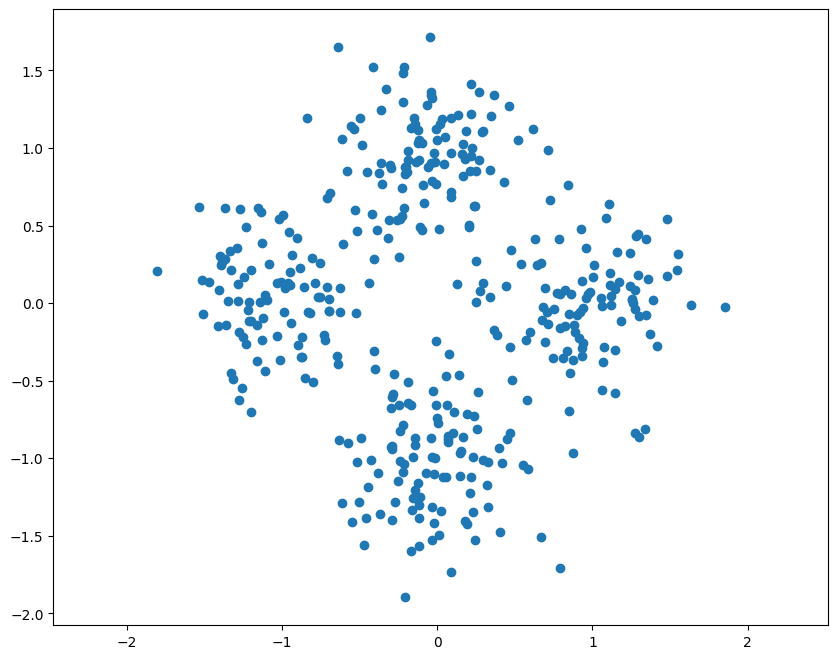

In [6]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (30 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested `for` loops to assign points to the closest centroid and compute a new mean for each cluster. (15 points)

In [7]:
from segmentation import kmeans

np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

ModuleNotFoundError: No module named 'segmentation'

We can use numpy functions and broadcasting to make K-Means faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run at least 10 times faster than the previous implementation. (15 points)

In [ ]:
from segmentation import kmeans_fast

np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("after optimization, kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 K-Means++ (15 points)
The benefits of K-Means algorithm include scalability, simplicity, flexibility, and interpretability. However, it is sensitive to initial conditions and fail to predict with bad initials.

To this end, K-Means++ algorithm is proposed to produce initial cluster centers. The optimize process is still the same with K-Means.

In [ ]:
from segmentation import kmeans_pp

np.random.seed(0)
start = time()
assignments = kmeans_pp(X, 4)
end = time()

kmeans_pp_runtime = end - start
print("kmeans++ running time: %f seconds." % kmeans_pp_runtime)
print("kmeans++ spend additional %f %% time to find good initials!" % ((kmeans_pp_runtime / kmeans_fast_runtime-1)*100))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.3 Mean Shift Clustering (15 points)

Mean Shift algorithm is another popular algorithm for clustering. Different with K-Means, Mean Shift finds arbitrary number of clusters using a hill climbing strategy. It is simple to implement, and more robust to outliers. It requires no initialization and the clustering result depends on the selection of window size w.

Implement **`mean_shift`** in `segmentation.py`.

**note: the original window size parameter is 0.25, but changing the window size to 1.75 in my implementation will result in a better performance**

In [ ]:
from segmentation import mean_shift

start = time()
# You may change window size of Mean Shift for better clustering results
assignments = mean_shift(X, 1.75)
# assignments = mean_shift(X, 1.75)

end = time()

mean_shift_runtime = end-start
print("mean shift clustering running time: %f seconds." % mean_shift_runtime)
print("mean shift is %f times slower than K-Means algorithm!" % ((mean_shift_runtime / kmeans_fast_runtime-1)))
# Mean Shift is more computational expensive than K-Means

current_class_number = max(assignments)
for i in range(current_class_number+1):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])


plt.axis('equal')
plt.show()

---
## Part 2. Pixel-Level Features for Segmentation (40 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vector* for each pixel. The feature vector for each pixel should encode the qualities that we care about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

In [ ]:
# Load and display image
img = io.imread('./data/train.jpg')
H, W, C = img.shape

plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (15 points)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. K-Means segmentation visualization should look like the following:

In [ ]:
plt.imshow(plt.imread('data/color_features.png'))
plt.axis('off')

In [ ]:
from segmentation import color_features
np.random.seed(0)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float32 or features.dtype == np.float64,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

In [ ]:
from utils import visualize_mean_color_image
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (25 points)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`. (15 points)

K-Means segmentation should look like the following:

In [ ]:
plt.imshow(plt.imread('data/color_position_features.png'))
plt.axis('off')

In [ ]:
from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float32 or features.dtype == np.float64,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
visualize_mean_color_image(img, segments)

Using color and position features, we may also implement segmentation with Mean Shift algorithm. Please finish the code in the cell below and compare segmentation results with the one implemented in K-Means. (10 points)

**Note: Since the meanshift is too slow, I used 2 extra methods downsize and upsize to resize the image for faster implementation, which takes about 1.5 minutes**

In [ ]:
from segmentation import color_position_features, downsize, upscale
np.random.seed(0)

scale = 2
img_downsized = downsize(img, scale)

# img_upscaled = upscale(img_downsized, scale)

# plt.imshow(img_downsized)

H, W, C = img_downsized.shape

# print(img.shape)
# print(img_downsized.shape)

features = color_position_features(img_downsized)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float32 or features.dtype == np.float64,\
    "dtype of color_features should be float."

# You may change window size of Mean Shift for better clustering results
assignments = mean_shift(features, 1)

segments = assignments.reshape((H, W))

segments = upscale(segments, img.shape[0], img.shape[1])

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
visualize_mean_color_image(img, segments)

### Extra Credit: Implement Your Own Feature (Optional, 10 points)
For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

Implement your feature extractor **`my_features`** in `segmentation.py`

Depending on the creativity of your approach and the quality of your writeup, implementing extra feature vectors can be worth extra credit.

**Describe your approach**: (YOUR APPROACH)

First, I still use color as a feature for segmentation, since color is indeed a really important aspect to distinguish objects. However, since the size of the feature vector is limited, I just use the grayness of the RGB value as one feature. This is possible since different objects tend to have different grayscale and same object tend to have same grayscale. I use the NTSC formula: 0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue to calculate the grayness.

Second, since position is also an important factor in determine which cluster does a pixel belong to, the x and y coordinate of the pixel should also be considered. But Since the total number of features is limited, I use the Euclidian distance from of the pixel to origin ($\sqrt{x^2+y^2}$) as the distance metric. By this method, the total number of features is reduced, and we still can guarantee that if 2 pixels are close to each other in position, their features will be similar, and if 2 pixels are far away from each other in position, their features will be different.

Lastly, when thinking about how humans distinguish objects, I think the texture of an object is also important. I searched on the internet and found many ways to represent texture like LBP, but they are to difficult to implement, so I thought of my way of using laplacian to represent texture. If a surface is smooth, then when we take the derivative, the derivative on that surface should be small. But when the texture is rough, then when we take derivative, the absolute value should be big since the there are a lot of intensity change on the surface. So I choose to take the laplacian (without guassian because my goal is to distinguish texure) of the pixels as a feature and set this value as the texture representation.

Finally, since I think grayness and position features are more important than laplacian feature, I normalize grayness and position features to [0, 2] but normalize laplacian feature to [0, 1], to give grayness and position features more weight.

In [ ]:
from segmentation import my_features

# Feel free to experiment with different images
# and varying number of segments
img = io.imread('./data/train.jpg')
num_segments = 8

H, W, C = img.shape

# Extract pixel-level features
features = my_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

---
**Acknowledgement**: This homework was developed based on a similar assignment from the computer vision course CS131 (Stanford) taught by Dr. Juan Carlos Niebles and  Prof. Ranjay Krishna.